In [71]:
import matplotlib.pyplot as plt
import cv2 as cv2
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
import shutil
import time
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from IPython.core.display import display, HTML
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
import numpy as np
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow import keras
import seaborn as sns
import os
sns.set_style('darkgrid')
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import confusion_matrix, classification_report


In [72]:
def set_plot_metadata(plt, xlabel, ylabel, title):
    plt.set_title(title)
    plt.set_ylabel(ylabel)    
    plt.set_xlabel(xlabel)

In [73]:
def tr_plot(tr_data, training_times, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc) + start_epoch
    epoch_arr=[]
    for i in range (start_epoch ,Epoch_count):
        epoch_arr.append(i+1) 
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='Best epoch= '+ str(index_loss + 1 + start_epoch)
    vc_label='Best epoch= '+ str(index_acc + 1 + start_epoch)
    fig,axes=plt.subplots(nrows = 1, ncols = 3, figsize = (20,8))
    axes[0].plot(epoch_arr,tloss, 'r', label= 'Training loss')
    axes[0].plot(epoch_arr,vloss,'g',label= 'Validation loss' )
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (epoch_arr,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (epoch_arr,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch,acc_highest, s =150, c = 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    training_times_cumu = [x/60 for x in training_times]
    training_times_cumu = [sum(training_times_cumu[0:i+1]) for i in range(0,len(training_times_cumu))]
    print(training_times_cumu)
    axes[2].plot (epoch_arr,training_times_cumu,'r',label= 'Epoch Training Times')
    axes[2].set_title('Epoch Training Times')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Training Time (in minutes)')
    axes[2].legend()    
    plt.tight_layout
    plt.show()

In [74]:
durations_arr = []
class vggTag(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, dwell, model_name, freeze, batches,
                 initial_epoch, epochs):
        super(vggTag, self).__init__()
        self.dwell = dwell
        self.model = model
        self.stop_patience = stop_patience
        self.epochs = epochs
        self.lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.patience = patience
        self.factor = factor
        self.threshold = threshold
        self.highest_tracc = 0
        self.lowest_vloss = np.inf
        self.initial_epoch = initial_epoch
        self.batches = batches

    def on_train_begin(self, logs=None):
        print('Epoch Loss Accuracy V_loss V_acc LR Next LR Monitor Duration')
    
    def on_epoch_begin(self, epoch, logs=None):
        self.now = time.time()

    def on_train_end(self, logs=None):
        print('Training is done')
        model.set_weights(vggTag.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        print('Batch = ' + str(batch) + '\tAccuracy = ' + str(logs.get('accuracy') * 100) + '\tLoss' + str(logs.get('loss')))

    def acc_gt_train_acc(self, accuracy, validation_loss, lr):
        self.stop_count = 0
        self.highest_tracc = accuracy
        vggTag.best_weights = self.model.get_weights()
        if validation_loss < self.lowest_vloss:
            self.lowest_vloss = validation_loss
        self.lr = lr
        self.count = 0
    
    def acc_lte_train_acc(self, validation_loss, lr):
        if self.count >= self.patience - 1:
            self.lr = self.factor + lr 
            tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)
            self.count = 0
            self.stop_count = self.stop_count + 1
            if self.dwell:
                self.model.set_weights(vggTag.best_weights)
            elif validation_loss < self.lowest_vloss:
                self.lowest_vloss = validation_loss
            else:
                self.count = self.count + 1
        
    
    def on_epoch_end(self, epoch, logs=None):
        validation_loss = logs.get('val_loss')
        accuracy = logs.get('accuracy') 
        validation_accuracy = logs.get('val_accuracy')
        loss = logs.get('loss')
        duration = time.time() - self.now
        durations_arr.append(duration)
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr = lr
        if accuracy < self.threshold:
            monitor = 'accuracy'
            if accuracy > self.highest_tracc:
                self.acc_gt_train_acc(accuracy, validation_loss, lr)
            else:
                self.acc_lte_train_acc(validation_loss, lr)
        else:
            monitor = 'val_loss'
            if validation_loss < self.lowest_vloss:
                self.lowest_vloss = validation_loss
                vggTag.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.lr = lr
            else:
                if self.count >= self.patience - 1:
                    self.lr = self.lr * self.factor
                    self.stop_count = self.stop_count + 1
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)
                    if self.dwell:
                        self.model.set_weights(vggTag.best_weights)
                    self.count = 0
                else:
                    self.count = self.count + 1
                if accuracy > self.highest_tracc:
                    self.highest_tracc = accuracy
        print(str(epoch + 1), str(self.epochs) + ' ', str(loss) + ' ', str(accuracy * 100), ' ', str(validation_loss), ' ', validation_accuracy, ' ', str(current_lr), ' ', str(self.lr), ' ', str(monitor), ' ', str(duration))
        if self.stop_count >= self.stop_patience:
            print('Training ends at {epoch + 1} post {self.stop_patience} learning rate changes')
            self.model.stop_training = True 

In [75]:
files_to_train = []
train_labels = []
test_df = pd.read_csv('../input/covidx-cxr2/test.txt', sep = " ", header=None)
test_df.columns = ['patient id', 'filenames', 'labels', 'data source']
test_df = test_df.drop(['patient id', 'data source'], axis=1)
train_txt = open("../input/covidx-cxr2/train.txt", "r")
train_list = train_txt.readlines()
destination = '../input/covidx-cxr2/train'
for line in train_list:
    split = line.split(' ')
    if len(split) > 4:
        fname = os.path.join(destination, split[2])
        label = split[3]
    else:
        fname = os.path.join(destination, split[1])
        label = split[2]
    files_to_train.append(fname)
    train_labels.append(label)
label_data = pd.Series(train_labels, name='labels')
file_data = pd.Series(files_to_train, name='filenames')
df = pd.concat([file_data, label_data], axis=1)
balance = df['labels'].value_counts()
print(df.head())
print(balance)

                                           filenames    labels
0          ../input/covidx-cxr2/train/ARDSSevere.png  negative
1  ../input/covidx-cxr2/train/acute-respiratory-d...  negative
2  ../input/covidx-cxr2/train/acute-respiratory-d...  negative
3  ../input/covidx-cxr2/train/ards-secondary-to-t...  negative
4  ../input/covidx-cxr2/train/pneumocystis-pneumo...  negative
positive    15994
negative    13992
Name: labels, dtype: int64


In [76]:
file_count = 5000
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print(df['labels'].value_counts()) 

positive    2158
negative    2158
Name: labels, dtype: int64


In [ ]:
img_size=(224, 224)
img_shape=(224, 224, 3)
train_split=0.9
train_df, valid_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=205)


batch_size=32

print ('train samples: ', len(train_df), '  test samples: ', len(test_df), ' validation samples', len(valid_df))


In [ ]:
def scalar(img):
    return img/125-1

In [77]:
gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = gen.flow_from_dataframe(train_df, x_col='filenames', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

length= len(test_df)

test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]  

test_steps=int(length/test_batch_size)  

test_gen=gen.flow_from_dataframe( test_df, '../input/covidx-cxr2/test', y_col='labels', x_col='filenames', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=gen.flow_from_dataframe(valid_df, x_col='filenames', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, 
                                  batch_size=batch_size)

train_steps=int(len(train_gen.labels)/batch_size)

train samples:  3884   test samples:  400  validation samples 432
Found 3884 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 432 validated image filenames belonging to 2 classes.


In [78]:
class_dict=train_gen.class_indices
classes=list(class_dict.keys()) 
model_name='VGG16'
class_count=len(classes)

base_model=tf.keras.applications.VGG16(include_top=False,input_shape=img_shape, weights="imagenet", pooling='avg')

In [79]:
input = base_model.output
input = keras.layers.BatchNormalization(axis=-1, epsilon=0.001, momentum=0.99)(input)
input = Flatten()(input)
input = Dropout(rate=0.3, seed=223)(input)
output = Dense(class_count, activation='softmax')(input)
model = Model(inputs=base_model.input, outputs=output)
model.compile(keras.optimizers.SGD(learning_rate = 0.0001, nesterov=True, decay=0.000001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

In [80]:
epochs = 40
patience= 2
threshold= 0.9
factor=0.5
stop_patience = 2
batches=train_steps
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
time_callback= TimeHistory()
callbacks=[vggTag(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=True, model_name=model_name, freeze=False, batches=batches,initial_epoch=0,epochs=epochs), time_callback]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch Loss Accuracy V_loss V_acc LR Next LR Monitor Duration
Batch = 0	Accuracy = 65.625	Loss0.5956379175186157
Batch = 1	Accuracy = 64.0625	Loss0.6034636497497559
Batch = 2	Accuracy = 66.66666865348816	Loss0.5989452600479126
Batch = 3	Accuracy = 71.09375	Loss0.565849781036377
Batch = 4	Accuracy = 71.875	Loss0.5546070337295532
Batch = 5	Accuracy = 73.4375	Loss0.5395494103431702
Batch = 6	Accuracy = 75.0	Loss0.5110040307044983
Batch = 7	Accuracy = 76.953125	Loss0.4825555384159088
Batch = 8	Accuracy = 77.08333134651184	Loss0.48140233755111694
Batch = 9	Accuracy = 78.125	Loss0.4663528800010681
Batch = 10	Accuracy = 79.82954382896423	Loss0.44685983657836914
Batch = 11	Accuracy = 80.46875	Loss0.4425242245197296
Batch = 12	Accuracy = 81.49038553237915	Loss0.42921769618988037
Batch = 13	Accuracy = 81.47321343421936	Loss0.4298234283924103
Batch = 14	Accuracy = 81.04166388511658	Loss0.439505398273468
Batch = 15	Accuracy = 81.4453125	Loss0.4256340563297272
Batch = 16	Accuracy = 81.80146813392639

In [81]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    true_class=[]
    pred_class=[]
    error_list=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             
    classes = list(new_dict.values())    
    dict_as_text=str(new_dict)
    dict_path=os.path.join(save_dir, subject + '-' +str(len(classes)) +'.txt'  )    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  
        if pred_index != true_index: 
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            prob_list.append(p[pred_index]) 
            pred_class.append(new_dict[pred_index])
            error_indices.append(true_index)           
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code<=errors:
                r=print_code
            else:
                r=errors           
            print('File   Class prediction   Actual   Class Probability')
            for i in range(r):
                print(error_list[i], pred_class[i], true_class[i], prob_list[i])               
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value)    
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(11)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title('Class wise error on test')
    
    if len(classes)<= 30:
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()    
        print("Classification report\n", clr)

[1.1592975735664368, 2.271320633093516, 3.381698274612427, 4.49347783724467, 5.5936501423517875, 6.7013831337293, 7.833333424727123, 8.933387688795726, 10.028844916820526, 11.129428815841676, 12.229666260878247, 13.327101878325147, 14.429489477475487, 15.533187850316368, 16.639132205645247, 17.74378153085709, 18.844394489129385]


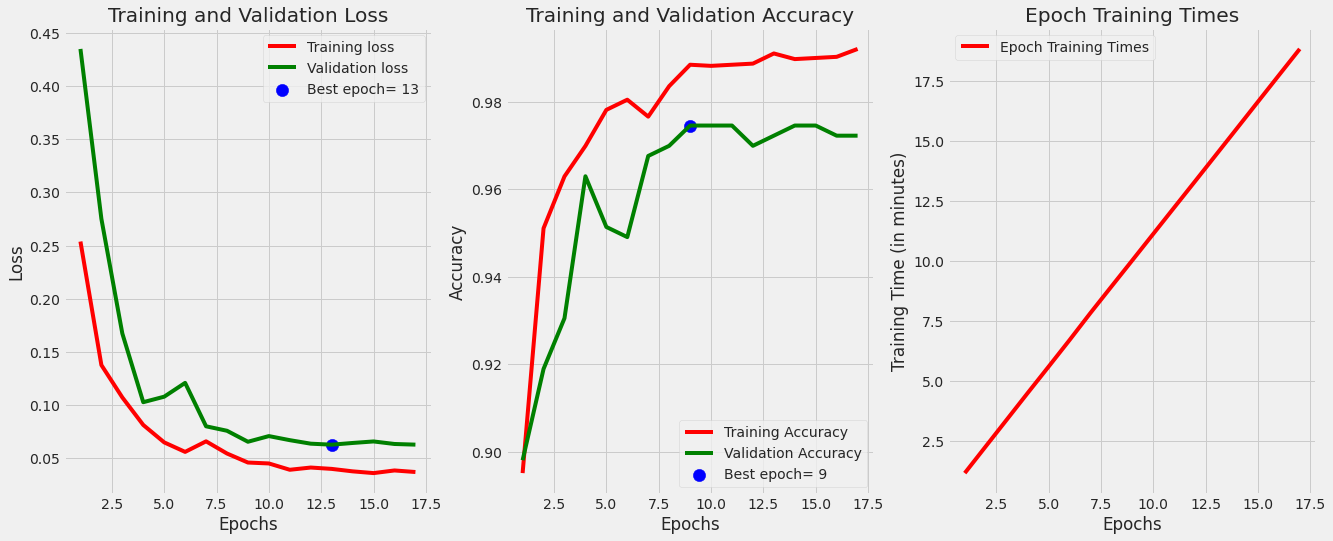

16/16 [==============================] - 29s 1s/step - loss: 0.0822 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9962 - true_positives: 388.0000 - true_negatives: 388.0000 - false_positives: 12.0000 - false_negatives: 12.0000
Model accuracy on test set: 97.00000286102295


In [82]:
tr_plot(history, durations_arr, 0)
acc=model.evaluate(test_gen,batch_size=test_batch_size, steps=test_steps, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print(msg)

[[9.75173956e-04 9.99024868e-01]
 [1.43533875e-03 9.98564661e-01]
 [1.13856122e-02 9.88614440e-01]
 [1.30360248e-03 9.98696387e-01]
 [5.72084403e-03 9.94279146e-01]
 [2.44977042e-01 7.55022883e-01]
 [1.17058789e-05 9.99988317e-01]
 [3.43504804e-03 9.96564925e-01]
 [9.52021554e-02 9.04797852e-01]
 [5.87347988e-03 9.94126558e-01]
 [1.71282832e-02 9.82871771e-01]
 [4.43335902e-03 9.95566666e-01]
 [6.79816008e-02 9.32018340e-01]
 [4.47271377e-01 5.52728593e-01]
 [1.28261764e-02 9.87173796e-01]
 [9.40793008e-03 9.90592062e-01]
 [5.46336591e-01 4.53663468e-01]
 [4.46656495e-02 9.55334425e-01]
 [2.22839117e-01 7.77160883e-01]
 [4.74699680e-03 9.95252967e-01]
 [4.71686886e-04 9.99528289e-01]
 [8.18152633e-03 9.91818428e-01]
 [1.51949900e-03 9.98480499e-01]
 [4.44087479e-03 9.95559096e-01]
 [3.63193721e-01 6.36806250e-01]
 [3.06981411e-02 9.69301879e-01]
 [3.79342407e-01 6.20657563e-01]
 [4.32152272e-04 9.99567807e-01]
 [1.05312996e-01 8.94687057e-01]
 [1.92555122e-03 9.98074412e-01]
 [5.889337

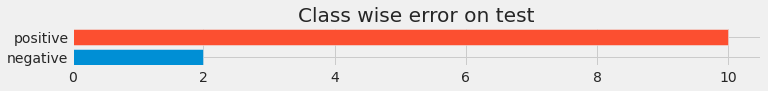

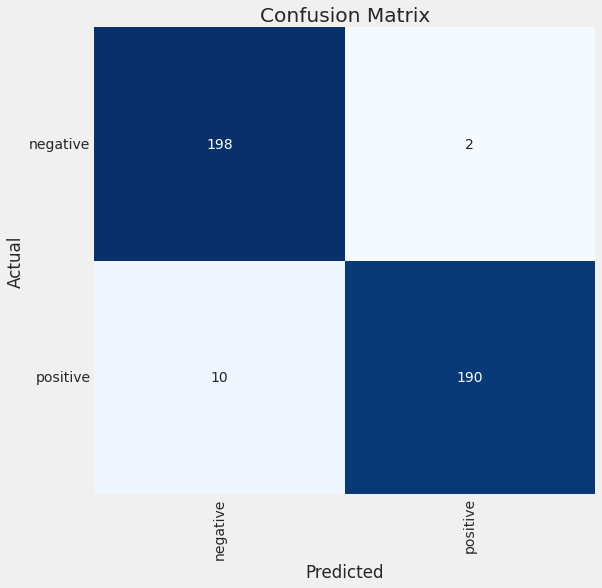

Classification Report:
----------------------
               precision    recall  f1-score   support

    negative       0.95      0.99      0.97       200
    positive       0.99      0.95      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



In [84]:
print_code=0
save_loc=os.path.join(r'./', str(model_name +  '-' + 'covid' +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5'))
model.save(save_loc)
preds=model.predict(test_gen) 
print(preds)
print_info( test_gen, preds, print_code, save_dir, "")

In [85]:
pip install opencv-python;

Note: you may need to restart the kernel to use updated packages.


In [ ]:


print(test_df.filenames)
tp = [test_df.filenames[i] for i in range(0, len(preds)) if preds[i][1] > preds[i][0] and test_df.labels[i] == 'positive']
fp = [test_df.filenames[i] for i in range(0, len(preds)) if preds[i][1] > preds[i][0] and test_df.labels[i] == 'negative']
tn = [test_df.filenames[i] for i in range(0, len(preds)) if preds[i][1] < preds[i][0] and test_df.labels[i] == 'negative']
fn = [test_df.filenames[i] for i in range(0, len(preds)) if preds[i][1] < preds[i][0] and test_df.labels[i] == 'positive']
tp_i = [i for i in range(0, len(preds)) if preds[i][1] > preds[i][0] and test_df.labels[i] == 'positive']
fp_i = [i for i in range(0, len(preds)) if preds[i][1] > preds[i][0] and test_df.labels[i] == 'negative']
tn_i = [i for i in range(0, len(preds)) if preds[i][1] < preds[i][0] and test_df.labels[i] == 'negative']
fn_i = [i for i in range(0, len(preds)) if preds[i][1] < preds[i][0] and test_df.labels[i] == 'positive']

def getAccuracy(val1, val2):
    return val2/(val1+val2)


import cv2
img = cv2.imread('../input/covidx-cxr2/test/'+tp[0])
plt.imshow(img)
plt.xticks([]), plt.yticks([]) 
plt.show()
print(getAccuracy(preds[tp_i[0]][0], preds[tp_i[0]][1]))
img = cv2.imread('../input/covidx-cxr2/test/'+tp[1])
plt.imshow(img)
plt.xticks([]), plt.yticks([]) 
plt.show()
print(getAccuracy(preds[tp_i[1]][0], preds[tp_i[1]][1]))

img = cv2.imread('../input/covidx-cxr2/test/'+fp[0])
plt.imshow(img)
plt.xticks([]), plt.yticks([]) 
plt.show()
img = cv2.imread('../input/covidx-cxr2/test/'+fp[1])
plt.imshow(img)
plt.xticks([]), plt.yticks([]) 
plt.show()
print(getAccuracy(preds[fn_i[1]][1], preds[fn_i[0]][0]))
print(getAccuracy(preds[fn_i[1]][1], preds[fn_i[1]][0]))

  
img = cv2.imread('../input/covidx-cxr2/test/'+tn[0])
plt.imshow(img)
plt.xticks([]), plt.yticks([]) 
plt.show()
img = cv2.imread('../input/covidx-cxr2/test/'+tn[1])
plt.imshow(img)
plt.xticks([]), plt.yticks([]) 
plt.show()
  
img = cv2.imread('../input/covidx-cxr2/test/'+fn[0])
plt.imshow(img)
plt.xticks([]), plt.yticks([]) 
plt.show()
img = cv2.imread('../input/covidx-cxr2/test/'+fn[1])
plt.imshow(img)
plt.xticks([]), plt.yticks([]) 
plt.show()

In [ ]:
results = {}
gs_lrs =  [0.1, 0.01, 0.001, 0.0001]
gs_optimizers =  ['adam', 'sgd', 'sgdm']
for l in gs_lrs:
    for gs_optimizer in gs_optimizers:
        opt = Adam(learning_rate = l)
        if gs_optimizer == 'adam':
            opt = Adam(learning_rate = l)
        elif gs_optimizer == 'sgdm':
            opt = keras.optimizers.SGD(learning_rate = l, decay=1e-6, momentum=0.9, nesterov=True)
        elif gs_optimizer == 'sgd':
            opt = keras.optimizers.SGD(learning_rate = l, decay=1e-6, momentum=0.0, nesterov=True)
        
        patience = 1
        stop_patience = 10
        factor = 0.5
        class TimeHistory(keras.callbacks.Callback):
            def on_train_begin(self, logs={}):
                self.times = []

            def on_epoch_begin(self, batch, logs={}):
                self.epoch_time_start = time.time()

            def on_epoch_end(self, batch, logs={}):
                self.times.append(time.time() - self.epoch_time_start)
            
        
        input = base_model.output
        input = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(input)
        input = Flatten()(input)
        input = Dropout(rate=0.3, seed=123)(input)
        output = Dense(class_count, activation='softmax')(input)
        model = Model(inputs=base_model.input, outputs=output)
        model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
        
        time_callback = TimeHistory()

        callbacks = [
            tf.keras.callbacks.ModelCheckpoint("classify_model.h5", save_best_only=True, verbose = 0),
            tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1),
            time_callback
        ]

        epochs = 10
        history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=callbacks, verbose=1)
        results[(gs_optimizer,l)] = history.history['val_accuracy'][-1]

In [ ]:
from sklearn.metrics import auc, confusion_matrix, classification_report, roc_curve

print_code=0
y_pred_keras=model.predict(test_gen)
print(y_pred_keras)
print_info( test_gen, y_pred_keras, print_code, save_dir, subject )  
new = y_pred_keras[:, 1]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.labels, new)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print(auc_keras)

In [ ]:
print(results)

In [ ]:
def plot_learning_rates(results):
    Adam =[]
    SGD = []
    SGDM = []
    
    for k,v in results.items():
        if(k[0] == 'adam'):
            Adam.append([k[1],v])
        if(k[0] == 'sgd'):
            SGD.append([k[1],v])
        if(k[0] == 'sgdm'):
            SGDM.append([k[1],v])   
    
    lrs = [x[0] for x in sorted(Adam, key = lambda x: x[0])]
    Adam = [x[1] for x in sorted(Adam, key = lambda x: x[0])]
    SGD = [x[1] for x in sorted(SGD, key = lambda x: x[0])]
    SGDM = [x[1] for x in sorted(SGDM, key = lambda x: x[0])]
      
    print(lrs, Adam, SGD, SGDM)
  
    plt.style.use('fivethirtyeight')
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(20,8))
    
    axes[0].plot(range(len(lrs)),Adam,'r',label= 'Validation Accuracy')
    axes[0].set_title('Adam')
    axes[0].set_xticks(range(len(lrs)))
    axes[0].set_xticklabels(lrs)
    axes[0].set_xlabel('Learning Rate')
    axes[0].set_ylabel('Validation Accuracy')
    axes[0].legend()  
    
    axes[1].plot (range(len(lrs)),SGD,'r',label= 'Validation Accuracy')
    axes[1].set_title('SGD')
    axes[1].set_xticks(range(len(lrs)))
    axes[1].set_xticklabels(lrs)    
    axes[1].set_xlabel('Learning Rate')
    axes[1].set_ylabel('Validation Accuracy')
    axes[1].legend() 
    

    axes[2].plot (range(len(lrs)),SGDM,'r',label= 'Validation Accuracy')
    axes[2].set_title('SGDM')
    axes[2].set_xticks(range(len(lrs)))
    axes[2].set_xticklabels(lrs)     
    axes[2].set_xlabel('Learning Rate')
    axes[2].set_ylabel('Validation Accuracy')
    axes[2].legend()
    plt.tight_layout
    plt.show()

In [ ]:
plot_learning_rates(results)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,1)

lrs =  [0.1, 0.01, 0.001, 0.0001]
opt =  ['adam', 'sgd', 'sgdm']

ax.set_yticks([0, 1, 2])
ax.set_yticklabels(opt)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(lrs)

arr = np.zeros([3, 3])

print(results)

for i in range(len(lrs)):
    for j in range(len(opt)):
        arr[i][j] = results[(opt[j], lrs[i])] * 100
        
arr = np.around(arr, 3)

plt.grid(False)
plt.xlabel('Learning rates')
plt.ylabel('Optimizers')
plt.title('Testing accuracy vs LR and Optimizers')
plt.imshow(arr, cmap='hot', interpolation='nearest')

for (j,i),label in np.ndenumerate(arr):
    ax.text(i,j,label,ha='center',va='center', color='green')

fig.savefig('heat_map_gs_lr_opt.png')
plt.show()